# Quantum Transformers

Code to implement the method proposed in ["Quantum Vision Transformers"](https://openreview.net/forum?id=p7xPXoKB0H). The paper ["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://quantum-journal.org/papers/q-2022-12-22-881/) is also used as a reference.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=150)
mpl.rcParams['figure.dpi'] = 50  # To make circuit plots smaller easily

## Reconfigurable Beam Splitter (RBS) gate

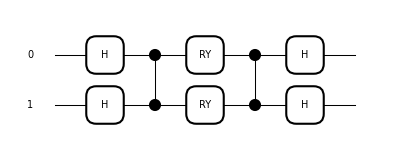

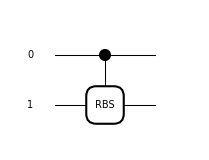

In [2]:
class RBS(qml.operation.Operation):
    """Reconfigurable Beam Splitter gate"""
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    @staticmethod
    def compute_matrix(theta):
        a = np.cos(theta)
        b = np.sin(theta)
        return np.array([[1, 0, 0, 0], [0, a, b, 0], [0, -b, a, 0], [0, 0, 0, 1]])

    @staticmethod
    def compute_decomposition(theta, wires):
        qml.Hadamard(wires=wires[0])
        qml.Hadamard(wires=wires[1])
        qml.CZ(wires=wires)
        qml.RY(theta / 2, wires=wires[0])
        qml.RY(-theta / 2, wires=wires[1])
        qml.CZ(wires=wires)
        qml.Hadamard(wires=wires[0])
        qml.Hadamard(wires=wires[1])

    @property
    def control_wires(self):
        return qml.wires.Wires(self.wires[0])

qml.draw_mpl(RBS.compute_decomposition)(np.pi / 2, wires=[0, 1]);
qml.draw_mpl(lambda theta: RBS(theta, wires=[0, 1]))(np.pi / 2);

## Diagonal circuit

### Vector data loader

In [3]:
def normalize(x):
    return x / np.linalg.norm(x)

n = 8

x = normalize(np.random.rand(n))
print(x)

[0.36181296 0.50150317 0.28560053 0.42014998 0.40298883 0.39709694 0.18878147 0.061383  ]


In [4]:
def get_thetas_diagonal(x):
    thetas = np.empty(len(x) - 1)
    acc = 1
    for i in range(len(x) - 1):
        thetas[i] = np.arccos(np.clip(x[i] / acc, -1, 1))
        acc *= np.sin(thetas[i])
    return thetas

x_thetas_diagonal = get_thetas_diagonal(x)
print(x_thetas_diagonal)

[1.20058445 1.00279437 1.19885872 0.95957102 0.83372517 0.46357058 0.31437094]


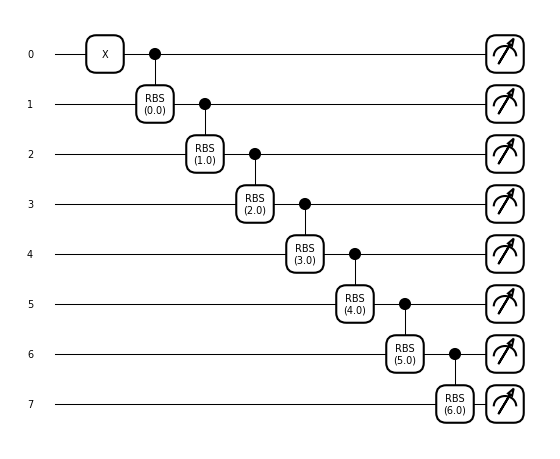

In [5]:
def diagonal_circuit(q: list[int], t: list[float], adjoint: bool = False, pauli_x: bool = False):
    if not adjoint:
        if pauli_x:
            qml.PauliX(wires=q[0])

        for i in range(len(q) - 1):
            RBS(t[i], wires=[q[i], q[i + 1]])
    else:
        for i in reversed(range(len(q) - 1)):
            RBS(-t[i], wires=[q[i], q[i + 1]])

        if pauli_x:
            qml.PauliX(wires=q[0])

@qml.qnode(qml.device('default.qubit', wires=n))
def diagonal_circuit_state(q, t):
    diagonal_circuit(q, t, pauli_x=True)
    return qml.state()

qml.draw_mpl(diagonal_circuit_state, wire_order=range(n), decimals=1)(range(n), range(n - 1));

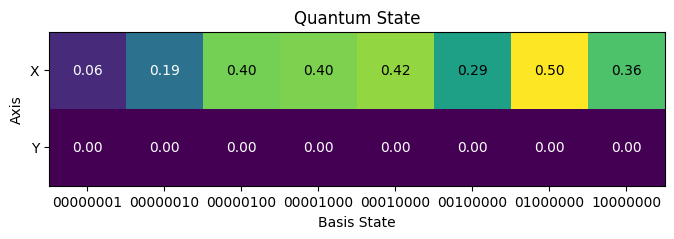

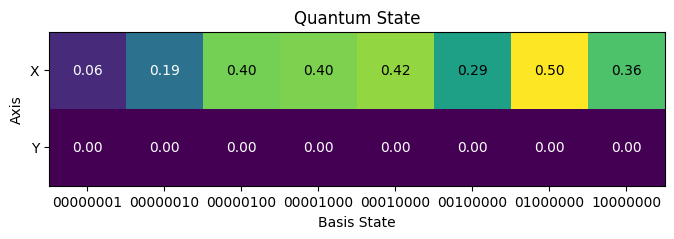

True

In [6]:
@qml.qnode(qml.device('default.qubit', wires=n))
def e(i):
    qml.PauliX(wires=i)
    return qml.state()

def get_x_state(x):
    result = 0
    for i in range(len(x)):
        result += x[i] * e(i)
    return result / np.linalg.norm(x)


def visualize_quantum_state(state, remove_zero_columns=False):
    fig, ax = plt.subplots(dpi=100, figsize=(8, 2))
    img = np.vstack((state.real, state.imag))
    state_labels = np.array([bin(i)[2:].zfill(int(np.log2(len(state)))) for i in range(len(state))])
    if remove_zero_columns:
        zero_columns = np.any(img, axis=0)
        img = img[:, zero_columns]
        state_labels = state_labels[zero_columns]
    ax.imshow(img)
    ax.set_xticks(range(img.shape[1]))
    ax.set_xticklabels(state_labels)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["X", "Y"])
    ax.set_ylabel("Axis")
    ax.set_xlabel("Basis State")
    ax.set_title("Quantum State")

    for i in range(img.shape[1]):
        for j in range(2):
            ax.text(i, j, f"{img[j, i]:.2f}", ha="center", va="center", color="w" if img[j, i] < 0.25 else "k")

    plt.show()

original_state = get_x_state(x)
diagonal_circuit_x_state = diagonal_circuit_state(list(range(n)), x_thetas_diagonal)
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(diagonal_circuit_x_state, remove_zero_columns=True)
np.allclose(original_state, diagonal_circuit_x_state)

### Square inner product

0.4526 0.45280637587588957


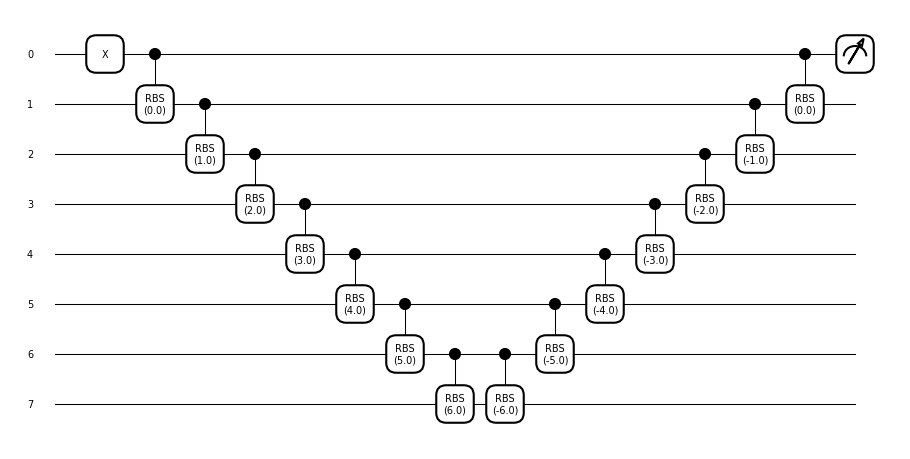

In [7]:
def diagonal_square_inner_product_circuit(q: list[int], x: list[float], w: list[float]):
    diagonal_circuit(q, x, pauli_x=True)
    diagonal_circuit(q, w, adjoint=True)
    return qml.probs(wires=q[0])

diagonal_square_inner_product_qnode = qml.QNode(diagonal_square_inner_product_circuit, qml.device('default.qubit', wires=n, shots=int(1 / 0.01**2)))
qml.draw_mpl(diagonal_square_inner_product_circuit, wire_order=range(n), decimals=1)(range(n), range(n - 1), range(n - 1));

w = normalize(np.random.rand(n))
w_thetas_diagonal = get_thetas_diagonal(w)

print(diagonal_square_inner_product_qnode(list(range(n)), x_thetas_diagonal, w_thetas_diagonal)[1], np.dot(x, w)**2)

## Semi-diagonal circuit

### Vector data loader

In [8]:
def get_thetas_semidiagonal(x):
    t = np.empty(len(x) - 1)
    t[1] = np.arctan2(x[0], x[1])
    t[-1] = np.arctan2(x[-1], x[-2])
    m = len(x) // 2 - 1
    for i in range(2, m+1):
        t[i] = np.arctan2(x[i-1], (x[i] * np.cos(t[i-1])))
    for i in range(len(x) - 3, m, -1):
        t[i] = np.arctan2(x[i+1], (x[i] * np.cos(t[i+1])))
    t[0] = np.arccos(x[m] / np.cos(t[m]))

    thetas = -np.ones_like(t)
    thetas[0] = t[0]
    for i in range(1, len(x)//2):
        thetas[-2*i] = t[i]
        thetas[-2*i+1] = t[-i]
    
    return thetas

x_thetas_semidiagonal = get_thetas_semidiagonal(x)
print(x_thetas_semidiagonal)

[0.64297216 1.01810555 0.83372517 1.13813952 0.46357058 0.62498195 0.31437094]


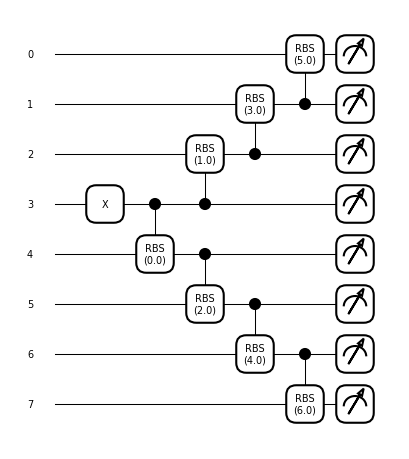

In [9]:
def semidiagonal_circuit(q: list[int], t: list[float], adjoint: bool = False, pauli_x: bool = False):
    m = len(q) // 2 - 1

    if not adjoint:
        if pauli_x:
            qml.PauliX(wires=q[m])

        for i in range(len(q) // 2):
            RBS(t[2*i], wires=[q[m+i], q[m+i+1]])
            if m-i-1 >= 0:
                RBS(t[2*i+1], wires=[q[m-i], q[m-i-1]])
    else:
        for i in reversed(range(len(q) // 2)):
            if m-i-1 >= 0:
                RBS(-t[2*i+1], wires=[q[m-i], q[m-i-1]])
            RBS(-t[2*i], wires=[q[m+i], q[m+i+1]])

        if pauli_x:
            qml.PauliX(wires=q[m])

@qml.qnode(qml.device('default.qubit', wires=n))
def semidiagonal_circuit_state(q, t):
    semidiagonal_circuit(q, t, pauli_x=True)
    return qml.state()

qml.draw_mpl(semidiagonal_circuit_state, wire_order=range(n), decimals=1)(range(n), range(n - 1));

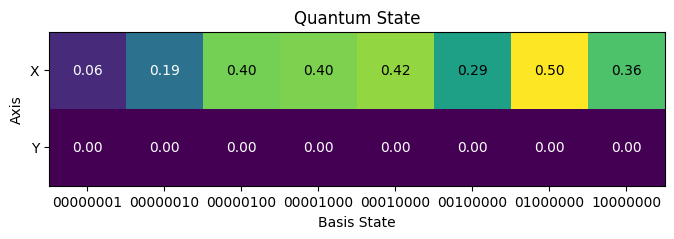

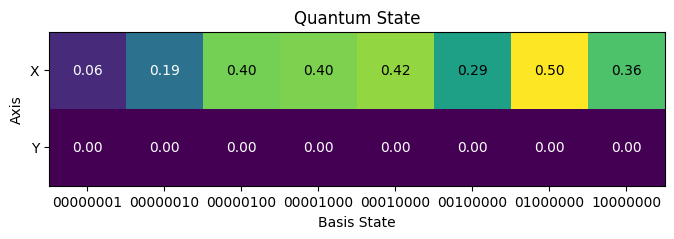

True

In [10]:
semidiagonal_circuit_x_state = semidiagonal_circuit_state(list(range(n)), x_thetas_semidiagonal)
visualize_quantum_state(original_state, remove_zero_columns=True)
visualize_quantum_state(semidiagonal_circuit_x_state, remove_zero_columns=True)
np.allclose(original_state, semidiagonal_circuit_x_state)

### Square inner product

0.4587 0.45280637587588957


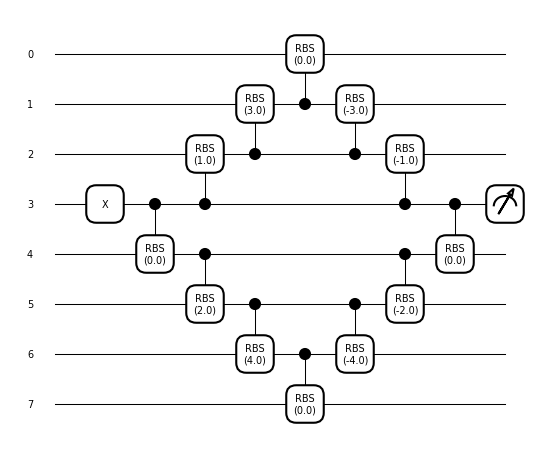

In [11]:
def semidiagonal_square_inner_product_circuit(q: list[int], x: list[float], w: list[float], pauli_x: bool = True, measure: bool = True):
    m = len(q) // 2 - 1
    semidiagonal_circuit(q[1:-1], x, pauli_x=pauli_x)
    RBS(x[-2] - w[-2], wires=[q[1], q[0]])
    RBS(x[-1] - w[-1], wires=[q[-2], q[-1]])
    semidiagonal_circuit(q[1:-1], w, adjoint=True)
    if measure:
        return qml.probs(wires=q[m])

semidiagonal_square_inner_product_qnode = qml.QNode(semidiagonal_square_inner_product_circuit, qml.device('default.qubit', wires=n, shots=int(1 / 0.01**2)))
qml.draw_mpl(semidiagonal_square_inner_product_circuit, wire_order=range(n), decimals=1)(range(n), range(n - 1), range(n - 1));

w_thetas_semidiagonal = get_thetas_semidiagonal(w)

print(semidiagonal_square_inner_product_qnode(list(range(n)), x_thetas_semidiagonal, w_thetas_semidiagonal)[1], np.dot(x, w)**2)

### Inner product

0.026693 0.026747148361587984
0.6732401493451192 0.6729088912147688


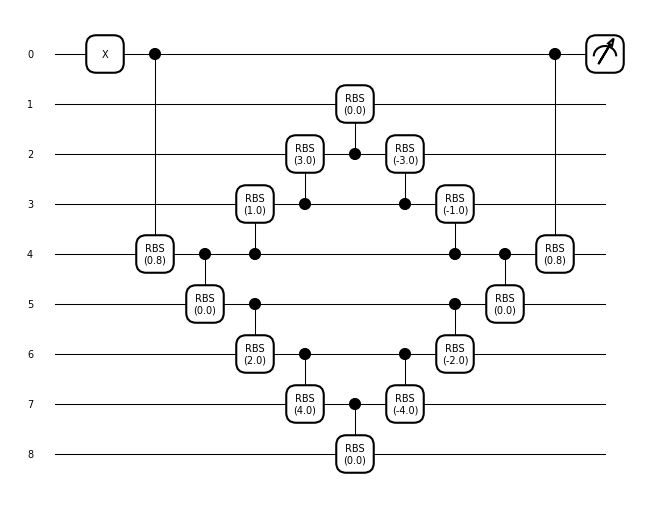

In [12]:
def semidiagonal_inner_product_circuit(q: list[int], x: list[float], w: list[float]):
    m = (len(q) - 1) // 2
    qml.PauliX(wires=q[0])
    RBS(np.pi / 4, wires=[q[0], q[m]])
    semidiagonal_square_inner_product_circuit(q[1:], x, w, pauli_x=False, measure=False)
    RBS(np.pi / 4, wires=[q[0], q[m]])
    return qml.probs(wires=q[0])

semidiagonal_inner_product_qnode = qml.QNode(semidiagonal_inner_product_circuit, qml.device('default.qubit', wires=n + 1, shots=int(1 / 0.001**2)))
qml.draw_mpl(semidiagonal_inner_product_circuit, wire_order=range(n), decimals=1)(range(n + 1), range(n - 1), range(n - 1));

output = semidiagonal_inner_product_qnode(list(range(n + 1)), x_thetas_semidiagonal, w_thetas_semidiagonal)[1]
print(output, (1/2 - np.dot(x, w)/2)**2)
print(1-2*np.sqrt(output), np.dot(x, w))

In [13]:
neg_w_thetas_semidiagonal = get_thetas_semidiagonal(-w)

output = semidiagonal_inner_product_qnode(list(range(n + 1)), x_thetas_semidiagonal, neg_w_thetas_semidiagonal)[1]
print(output, (1/2 - np.dot(x, w)/2)**2)
print(1-2*np.sqrt(output), np.dot(x, -w))

0.699299 0.026747148361587984
-0.6724819879448627 -0.6729088912147688


In [14]:
perp_w = normalize(scipy.linalg.null_space(np.atleast_2d(x))[:, 0])
perp_w_thetas_semidiagonal = get_thetas_semidiagonal(perp_w)

output = semidiagonal_inner_product_qnode(list(range(n + 1)), x_thetas_semidiagonal, perp_w_thetas_semidiagonal)[1]
print(output, (1/2 - np.dot(x, perp_w)/2)**2)
print(1-2*np.sqrt(output), np.dot(x, perp_w))

0.249603 0.2499999999999999
0.0007943154685318143 2.3830763751231387e-16
